In [2]:
# Implementing the paper "https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf"
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [130]:
import numpy as np

In [ ]:
"""
The crux of the paper
1. To understand a distributed representation of words. Each sentence will inform the model about an exponential number of sementically similar sentences in its neighbourhood.
2. The goal is to evaluate distributed representation of each word as well as to calculate the probability function for word sequences and express them in terms of these representaions.

Why the problem is difficult?
1. For a corpus of 100000 words, the probability distribution of 10 consequtive words have 100000^10 free parameters. When a random variable can take such large possible values,
most observed objects are very far from each other. [Curse of Dimensionality].
"""

In [4]:
# Read data
names =open('names.txt', 'r').read().splitlines()
print(names[:10])
print('No. of names', len(names))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
No. of names 32033


In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(names))))
char2int = {s:i+1 for i,s in enumerate(chars)}
char2int['.'] = 0
int2char = {i:s for s,i in char2int.items()}
print(int2char)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [9]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []

for name in names[:1]:
  #print(w)
  context = [0] * block_size
  for ch in name + '.':
    ix = char2int[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(int2char[i] for i in context), '--->', int2char[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .


In [25]:
def build_dataset(words, context_len=3):
    block_size = context_len  # context length: How many charasters are used to predict the next character.
    X = []
    y = []

    for name in words:
        context = [0] * block_size     # Initializing the tokens with '.' (start token)

        for char in name + '.':
            ix = char2int[char]
            X.append(context)
            y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    y = torch.tensor(y)

    # print(X.shape)
    # print(y.shape)

    return X, y

In [26]:
import random

In [28]:
# Separating the training, evaluation and test sets.
n_data = len(names)
random.seed(42)
random.shuffle(names)
n1 = int(0.8*n_data)
n2 = int(0.9*n_data)
Xtrain, ytrain = build_dataset(names[:n1])
Xeval, yeval = build_dataset(names[n1:n2])
Xtest, ytest = build_dataset(names[n2:])

print('Training data shape', Xtrain.shape)
print('Evaluation data shape', Xeval.shape)
print('Testing data shape', Xtest.shape)

Training data shape torch.Size([182441, 3])
Evaluation data shape torch.Size([22902, 3])
Testing data shape torch.Size([22803, 3])


In [29]:
Xtrain 

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 12],
        ...,
        [ 0, 14, 15],
        [14, 15, 14],
        [15, 14,  9]])

In [44]:
# Create embeddings for each word. Earlier we have used embeddings of dimension 27 as one-hot-encoddings. 
# As stated the objective of the paper is to learn the word representation as well, we can shoose any arbitrary dimension to represent each characters.
# We will use 2, so that we can visualize the final representation of characters.

In [ ]:
# The neural network used in this project
"""
            [[ch1],
             [ch2],     --->
             [ch3]
             ]
"""

In [63]:
# Generate the neural network parameters
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)    # Represent each characters using 2 dimensional vector.
W1 = torch.randn((6, 100), generator=g)  # The first hidden layer has a 100 neuron. To provide input, we need to convert the three character seq each of dimension two.
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g) # The output layer of the network. We are essentially trying the predic the next(4th.) character out of total 27.
b2 = torch.randn(27, generator=g)           

In [50]:
# Working with the torch tensor
a2 = torch.randn((4, 2))
a1 = a2.view(8)
a3 = a2.view((2, 2, 2))
print('Original generated array', a2.shape, '\n', a2)
print('Flattening the 2d array into 1d', a1.shape, '\n', a1)
print('Flattening the 2d array into 3d', a3.shape, '\n', a3)

Original generated array torch.Size([4, 2]) 
 tensor([[-0.1961,  1.5562],
        [-2.0607, -0.1831],
        [ 0.3981, -0.9136],
        [-0.0888, -0.9157]])
Flattening the 2d array into 1d torch.Size([8]) 
 tensor([-0.1961,  1.5562, -2.0607, -0.1831,  0.3981, -0.9136, -0.0888, -0.9157])
Flattening the 2d array into 3d torch.Size([2, 2, 2]) 
 tensor([[[-0.1961,  1.5562],
         [-2.0607, -0.1831]],

        [[ 0.3981, -0.9136],
         [-0.0888, -0.9157]]])


In [52]:
# Converting a 3d tensor into 1 d tesnor
a31 = a3.view(-1, 4)
a31.shape

torch.Size([2, 4])

In [126]:
# Forward pass
emb = C[Xtrain]     # Shape = (182441, 3, 2)
h1 = torch.tanh(emb.view(-1, 6)@W1+b1)

# Calulating the cross entropy loss.
logits = h1 @ W2 + b2
count = logits.exp()
prob = count / count.sum(1, keepdim=True)
loss = -prob[ytrain].log().mean()
print(loss)

# Easier and more effecient way of calculating cross entropy loss.
loss = F.cross_entropy(logits, ytrain)
print(loss.item())
print(prob.shape)

tensor(nan, grad_fn=<NegBackward0>)
233.28292846679688
torch.Size([182441, 27])


In [127]:
# Backward Pass
params = [W1, b1, W2, b2]

for p in params:
    p.requires_grad = True

for p in params:
    p.grad = None

loss.backward()

for p in params:
    p.data += -0.1 * p.grad

In [137]:
# Combining the forward and backward pass
lossi = []
for _ in range(200):
    # Forward pass
    h1 = torch.tanh(emb.view(-1, 6)@W1+b1)

    # Calulating the cross entropy loss.
    logits = h1 @ W2 + b2
    count = logits.exp()
    prob = count / count.sum(1, keepdim=True)
    loss = -prob[ytrain].log().mean()
    # print(loss)

    # Easier and more effecient way of calculating cross entropy loss.
    loss = F.cross_entropy(logits, ytrain)
    # print(loss.item())
    # print(prob.shape)
    lossi.append(loss.item())

    # Backward pass
    loss.backward()

    for p in params:
        p.data += -0.1 * p.grad

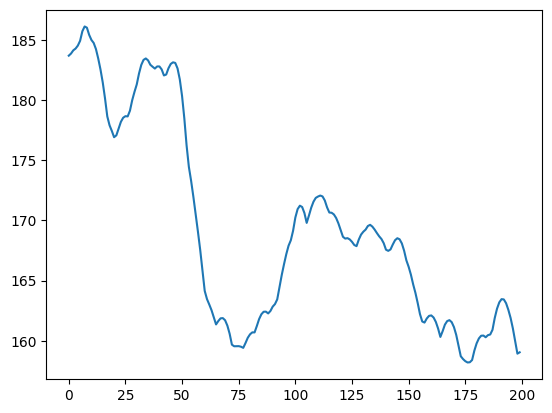

In [139]:
plt.plot(np.arange(200), lossi)

In [140]:
lri = []
lossi = []
stepi = []

In [146]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtrain.shape[0], (32,))
  
  # forward pass
  emb = C[Xtrain[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, ytrain[ix])
  #print(loss.item())
  
  # backward pass
  for p in params:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in params:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

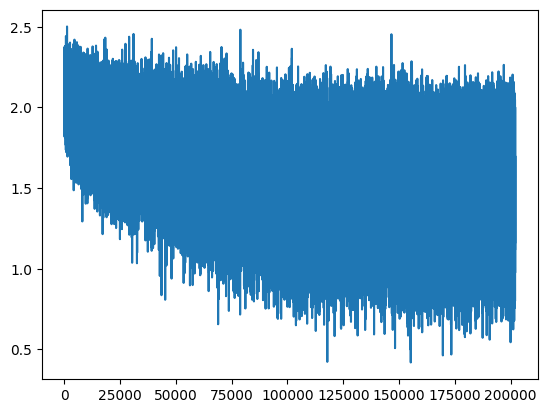

In [150]:
plt.plot(np.arange(len(lossi)), lossi)

In [151]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(int2char[i] for i in out))

eriahitymunzalmon.
hfirdelennacderlyne.
cahe.
koietileelynneiledzhszanyaaslea.
zijzhynahnelvx.
mrahawydfhsri.
jowbayconn.
podmibbhyne.
ariyah.
firdel.
mahgeesnyan.
hynidv.
yhraylee.
jooy.
jowbayco.
ki.
jaisn.
povlin.
qpjhtrh.
g.
